In [1]:
from datetime import datetime
import os
PATH = os.getcwd()
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
import networkx
from networkx import *
import sys
from pathlib import Path
p = (Path('.') / 'seirsplus').resolve()
if str(p) not in sys.path:
    sys.path.insert(0,str(p))

In [2]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from seirsplus.parallel_run import *

## Parameter setup

### Social network

In [3]:
def get_network(N, p = 0.2):
    return {
    "G": Defer(gaussian_random_partition_graph,N, 20, 5, 0.5, 5/(N-20), directed=False),
    "N": N,
    "isolation groups": None,
    "p": p
    }

In [4]:
def random_graph(N,d, p =0.2):
    return {
        "G": Defer(fast_gnp_random_graph,N,d/N),
        "N": N,
        "p": p,
        "isolation groups": None
    }
        

### Infection parameters

In [5]:
def infect_params(N,R0_mean, R0_coeffvar= None, average_introductions_per_day = 0, single_intro_by =None,):
    latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
    SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)
    presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
    LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)
    symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
    GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)
    infectiousPeriod = 1/LAMDA + 1/GAMMA
    onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
    ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)
    hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
    GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)
    hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
    MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)
    PCT_FATALITY = 0.08
    PCT_HOSPITALIZED = 0.035
    P_GLOBALINTXN = 0.4
    if R0_coeffvar is None:
        R0_coeffvar = R0_mean/10
    R0 = gamma_dist(R0_mean, R0_coeffvar, N)
    BETA = 1/infectiousPeriod * R0
    return dict(beta=BETA, sigma=SIGMA, lamda=LAMDA, 
                   gamma=GAMMA, 
                   gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                    isolation_time=14, 
               average_introductions_per_day = average_introductions_per_day,
               introduction_days = [] if single_intro_by is None else Defer(single_introduction,single_intro_by)) 

In [6]:
def infect_params_orig(N,R0, average_introductions_per_day = 0, single_intro_by =None, skip_pre= False, pct_symptomatic= 0, pre_symptomatic_period=3, infectious_period = 6.5, incubation_period = 5.2):
    ETA = 0
    MU_H    = 0 
    PCT_FATALITY = 0
    PCT_HOSPITALIZED = 0
    PCT_ASYMPTOMATIC = 1-pct_symptomatic
    BETA = R0/infectious_period
    if skip_pre:
        lamda = 0
        gamma = 1/infectious_period
    else:
        gamma = 1/pre_symptomatic_period
        lamda = 1/(infectious_period-pre_symptomatic_period)
    if not (single_intro_by is None):
        print("***",single_intro_by)
        introduction_days = Defer(single_introduction,single_intro_by)
    else: 
        introduction_days = []
    return dict(skip_pre=skip_pre,beta=BETA, sigma=1/incubation_period, lamda= lamda, 
                   gamma=gamma, 
                   gamma_asym=gamma, eta=ETA, gamma_H=gamma, mu_H=MU_H, 
                a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                    isolation_time=14, 
               average_introductions_per_day = average_introductions_per_day,
               introduction_days = introduction_days ) 

### Testing and intervention parameters

In [7]:
def run_params(N,frac_tested,frequency, testing_compliance_symptomatic=0):
    MAX_TIME = 105
    D=  dict(T = MAX_TIME,
    runTillEnd = False,
    intervention_start_pct_infected = 0/100,
    initI = 0, # initial number of infected people
    #testing_cadence                 = testing_cadence,      # how often to do testing (other than self-reporting symptomatics who can get tested any day)
    #cadence_testing_days = cadence_testing_days, # dictionary mapping testing_cadence to schedule (None =  default weekly/workday/etc..)
    pct_tested_per_day              = frac_tested,           # max daily test allotment defined as fraction of population size
    test_falseneg_rate              = 0.25,    # test false negative rate, will use fn rate that varies with disease time
    max_pct_tests_for_symptomatics  = 1,           # max percent of daily test allotment to use on self-reporting symptomatics
    max_pct_tests_for_traces        = 1,           # max percent of daily test allotment to use on contact traces
    random_testing_degree_bias      = 0,             # magnitude of degree bias in random selections for testing, none here

    pct_contacts_to_trace           = 0.0,           # percentage of primary cases' contacts that are traced
    tracing_lag                     = 2,             # number of cadence testing days between primary tests and tracing tests

    isolation_lag_symptomatic       = 1,             # number of days between onset of symptoms and self-isolation of symptomatics
    isolation_lag_positive          = 1,             # test turn-around time (tat): number of days between administration of test and isolation of positive cases
    isolation_lag_contact           = 0,             # number of days between a contact being traced and that contact self-isolating


    testing_compliance_symptomatic                  = testing_compliance_symptomatic,    
    testing_compliance_traced                       = 0,
    testing_compliance_random                       = 1,  # assume employee testing is mandatory, so 100% compliance

    tracing_compliance                              = 0.0,

    isolation_compliance_symptomatic_individual     = 0.0,
    isolation_compliance_symptomatic_groupmate      = 0.0,
    isolation_compliance_positive_individual        = 0.0,
    isolation_compliance_positive_groupmate         = 0.0,  # isolate teams with a positive member, but suppose 20% of employees are essential workforce
    isolation_compliance_positive_contact           = 0.0,
    isolation_compliance_positive_contactgroupmate  = 0.0,
    test_priority = 'last_tested',
    stopping_policy = Defer(stop_at_detection,lag=1), 
    budget_policy = scale_to_pool # fraction of tests is determined as fraction of eligible pool
    )
    if isinstance(frequency,str):
        D["testing_cadence"] = frequency
    else:
        D[("testing_cadence","cadence_testing_days","cadence_cycle_length")] = Defer(test_frequency,frequency)
    return D
    



## Set up experiment

In [8]:
totals = [1,2,7,14,28,35,52]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0
# heat map budget
network = random_graph(500, 15)
for total in totals:
    for f in [1,total]: 
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = network['N']
            D = {"N":N,
                 "frequency":f,
                 "experiment" : "varying_total",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun.append(D)
# 28 days 
for total in [28]:
    for f in [1,7,14,total]:
        for G in ["random","gaussian_random_partition"]:
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = 500
                if G=='random':
                    network = random_graph(500, 15)
                else:
                    network = get_network(500,0.5)
                D = {"N":N,
                     "frequency":f,
                     "experiment" : f"28_days_G_{G}",
                     "type": f"freq={f}/tot={total}/R={R}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initE": INIT_INFECT,
                     "runTillEnd": INIT_INFECT>0,
                    }
                torun.append(D)


for total in [28]:
    for f in [1,7,14,total]:
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = 500
            network= random_graph(500, 15)
            D = {"N":N,
                 "frequency":f,
                 "experiment" : f"28_days_symptomatic",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=False,pct_symptomatic=0.5),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0.25),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun.append(D)

        

# no testing            
for total in totals:
    for N in [2000]:
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            network = random_graph(2000, 15)
            D = {"frequency":1,
                 "experiment" : f"effective_R_{N}_nodes",
                 "type": f"NoTesting/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,single_intro_by=None,skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=0,frequency=1, testing_compliance_symptomatic=0.5),
                 "initE":INIT_INFECT,
                 "T": total,
                 "runnTillEnd": True,
                 #"intervention_start_pct_infected": 1.1 # don't do any interventions
                }
            torun.append(D)

# external infection
network = random_graph(500, 15)
for total in [28]:
    for rate in [1/14,1/10,1/7,1/3.5,1/2]:
        for f in [1,7,28]:# [1]+totals:
            if total % f: continue
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = network['N']
                D = {"N":N,
                     "frequency":f,
                     "experiment" : "external_introductions",
                     "type": f"freq={f}/tot={total}/R={R}/ext={rate}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = rate, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initI_asym": 0,
                     "runTillEnd": True
                    }
                torun.append(D)

        
        
realizations = 400

file_prefix = f"all_versions"
file_prefix

'all_versions'

In [9]:
totals = [1,2,7,14,28,35,52]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0

for total in [28]:
    for f in [1,7,14,total]:
        for G in ["gaussian_random_partition"]:
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = 500
                if G=='random':
                    network = random_graph(500, 15)
                else:
                    network = get_network(500)
                D = {"N":N,
                     "frequency":f,
                     "experiment" : f"28_days_G_{G}",
                     "type": f"freq={f}/tot={total}/R={R}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initE": INIT_INFECT,
                     "runTillEnd": INIT_INFECT>0,
                    }
                torun.append(D)
       
realizations = 400

file_prefix = f"all_versions"
file_prefix

'all_versions'

In [10]:
# Rs = [2,3.2,4.8]
# torun = []

# INIT_INFECT = 1
# INTRO_DAY = 0

# for total in [28]:
#     for f in [1,14,total]:
#         G = 'random'
#         for pre_symptomatic_period in [3,6.4]:
#             for R in Rs: #numpy.linspace(1.0,4.0,15):
#                 N = 500
#                 if G=='random':
#                     network = random_graph(500, 15)
#                 else:
#                     network = get_network(500,0.5)
#                 D = {"N":N,
#                      "frequency":f,
#                      "experiment" : f"28_days_G_{G}_pre_{pre_symptomatic_period}",
#                      "type": f"freq={f}/tot={total}/R={R}",
#                      "R":R,
#                      "total": total,
#                      **network, 
#                      **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=False, pre_symptomatic_period=6.4),
#                      **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
#                      "initI_asym": INIT_INFECT,
#                      "runTillEnd": INIT_INFECT>0,
#                     }
#                 torun.append(D)

# for total in [28]:
#     for f in [1,14,total]:
#         G = 'random'
#         for test_per in [0.1,0.5]:
#             for pre_symptomatic_period in [3]:
#                 for R in Rs: #numpy.linspace(1.0,4.0,15):
#                     N = 500
#                     if G=='random':
#                         network = random_graph(500, 15)
#                     else:
#                         network = get_network(500,0.5)
#                     D = {"N":N,
#                          "frequency":f,
#                          "experiment" : f"28_days_G_{G}_symptomatic_{test_per}_pre_{pre_symptomatic_period}",
#                          "type": f"freq={f}/tot={total}/R={R}",
#                          "R":R,
#                          "total": total,
#                          **network, 
#                          **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=False, pre_symptomatic_period=6.4,pct_symptomatic=0.5),
#                          **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=test_per),
#                          "initI_asym": INIT_INFECT,
#                          "runTillEnd": INIT_INFECT>0,
#                         }
#                     torun.append(D)        
# realizations = 400

# file_prefix = f"testing"
# file_prefix

In [11]:
len(torun)*realizations

16000

## Run several experiments in parallel

In [12]:
os.chdir(PATH)
if not os.path.exists("data/"):
    os.makedirs("data")

timestamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
datadir = f"data/{timestamp}_{realizations}"
os.makedirs(datadir)
torun_fname = datadir+"/torun.pickle"
save_to_file(torun,torun_fname)
print(datadir)

os.chdir("seirsplus")

data/20201106_23_41_23_400


In [13]:
%%time
!python -m seirsplus.parallel_run --torun "../$torun_fname" --realizations $realizations --savename "../$datadir/data"

Arguments:
torun : ../data/20201106_23_41_23_400/torun.pickle
realizations : 400
savename : ../data/20201106_23_41_23_400/data
Loading torun
Loaded
Preparing list to run
Starting execution of 16000 runs
100%|█████████████████████████████████████| 16000/16000 [19:18<00:00, 13.81it/s]
done
Saving csv
Saving split parts
Saving pickle 1
Done
CPU times: user 27.7 s, sys: 3.86 s, total: 31.6 s
Wall time: 19min 28s


In [9]:
datadir ='data/20201020_14_12_29_400'

In [14]:
2

2

In [15]:
datadir

'data/20201106_23_41_23_400'

In [16]:
os.chdir(PATH)
data = read_from_file(datadir+"/data")

Loading chunk 1


In [17]:
filename = file_prefix + "_" + datadir.split('/')[1]+".csv"
data.to_csv(filename)
print(filename)

all_versions_20201106_23_41_23_400.csv


In [18]:
len(data)

16000

In [19]:
data.experiment.unique()

array(['28_days_G_gaussian_random_partition'], dtype=object)

In [20]:
def censor(df):
    return df[df['numPositive/sum']>0]

def restrict(df,total,R):
    return df[(df.total==total) & (df.R==R)]

def summarize(df, percentile=0.9):
    print(f"Total: {df.total.unique()} R: {df.R.unique()} min(numPositive/sum): {df['numPositive/sum'].min()}")
    print(f"Frequency: risk(mean),risk({percentile*100:.0f}%) | overall(mean),overall({percentile*100:.0f}%)")
    for i in sorted(df.frequency.unique()):
        s = df[df.frequency==i]
        t=s['numInfectious/average']
        u = s['overallInfected/last']
        print(f"{i:02d}:        {t.mean():.2f}, {t.quantile(percentile):.2f}           "+
               f"| {u.mean():.2f} , {u.quantile(percentile):.1f}                   "+
               f"| count={t.count()} ")
summarize(censor(restrict(data,total=28,R=2.0)))

Total: [28] R: [2.] min(numPositive/sum): 1.0
Frequency: risk(mean),risk(90%) | overall(mean),overall(90%)
01:        1.52, 2.66           | 8.31 , 21.0                   | count=251 
07:        1.64, 2.76           | 8.98 , 20.0                   | count=248 
14:        1.71, 2.87           | 9.84 , 25.0                   | count=243 
28:        1.66, 2.83           | 10.12 , 24.0                   | count=252 


In [21]:
def summary(df,fields = ['numInfectious/average','overallInfected/last','time/last'], p=0.9):
    def top(x): return x.quantile(p) 
    print(f"Total: {df.total.unique()} R: {df.R.unique()} min(numPositive/sum): {df['numPositive/sum'].min()}")
    D =  {f: ['mean',top] for f in fields}
    D[fields[0]].insert(0,'count')
    return df.fillna(0).groupby('frequency')[fields].agg(D)

In [22]:
summary(censor(restrict(data,total=28,R=2.8)))

Total: [28] R: [2.8] min(numPositive/sum): 1.0


numInfectious/average                     overallInfected/last  \
                          count      mean       top                 mean   
frequency                                                                  
1                           288  1.868127  3.414602            12.468750   
7                           301  1.972689  3.549625            13.747508   
14                          295  1.929901  3.476424            13.467797   
28                          285  2.101083  3.954314            15.743860   

                 time/last             
            top       mean        top  
frequency                              
1          28.0  17.236678  30.544793  
7          33.0  17.535796  33.241136  
14         35.0  17.499627  33.409971  
28         37.2  18.109760  33.881730

In [23]:
total = 28
show_violins(censor[(censor.total==total) & (censor.R==2.8)],
             field = "numInfectious/average", 
             ylabel ="Social risk until 1st detection", 
             groupby="frequency", 
             title=f"Overall num of infected when testing 100% per {total} days")

AttributeError: 'function' object has no attribute 'total'

In [24]:
def panels(data, yfield):
    daily = data[data.frequency==1]
    batch = data[data.frequency==data.total]
    panel1 = daily.groupby([yfield,"R"])["overallInfected/last"].mean().unstack()
    panel2 = batch.groupby([yfield,"R"])["overallInfected/last"].mean().unstack()
    panel3 = panel1/panel2*100
    return panel1,panel2,panel3

    

In [25]:
from matplotlib.colors import ListedColormap
def colormap(minval,midval,maxval, scale = "RdBu_r"):
    minval,midval,maxval = int(minval), int(midval), int(maxval)
    n = (maxval-minval)*10
    L = sns.color_palette(scale, n).as_hex()
    L1 = L[0:n//2:n//(2*(midval-minval))]
    L2 = L[n//2:n:n//(2*(maxval-midval))]
    return ListedColormap(L1+L2)
    
    
#greens = list(sns.color_palette("BuGn_d",(midval-minval)//2).as_hex())[::-1]
#L = greens + L1

#cmap_percentages = ListedColormap(L)
#L1 = sns.color_palette("RdBu_r", 2*MAX-10).as_hex()
#greens = list(reversed(sns.color_palette("BuGn_d",10).as_hex()))
#L = greens+L1[0:MAX:(MAX//10)] + L1[MAX:]
#from matplotlib.colors import ListedColormap
#cmap_numbers = ListedColormap(L)


In [26]:
from matplotlib.ticker import StrMethodFormatter 

def heatmap(data, yfield, ytitle, maxper = None, tight= False, maxval= 100):
    panel1,panel2,panel3 = panels(data,yfield)
    print(max(*panel1.values.flatten(),*panel2.values.flatten()))
    if maxval is None:
        maxval = max(*panel1.values.flatten(),*panel2.values.flatten())
    if not maxper:
        maxper = max(panel3.values.flatten())
    cmap_numbers = colormap(0,10,max(11,maxval))
    cmap_percentages = colormap(0,100,max(maxper,101), scale = 'RdYlGn_r')
    
    print(data.total.unique())
    

    size = 30
    titlesize = 40

    fig , axes = plt.subplots(1,3, sharex=True, sharey= True, figsize= (28,10))
    cbar_ax = fig.add_axes([-0.05, 0.15, .03, .7])
    #axes[0].title.set_text('28/4 vs baseline')
    #cmap = sns.diverging_palette(150, 275, sep=1,s=80, l=55, n=25)
    #fig.suptitle(f'Daily vs Batch testing - {statistic} overall infected individuals', fontsize=int(titlesize*1.1), color="blue")
    #fig.subplots_adjust(top=1)


    fmt = ".1f" 

    color = "white"
    axes[0].set_title("a) Cost with daily testing",loc="left",fontsize=int(titlesize))
    sns.heatmap(panel1,ax=axes[0],cbar=True, cbar_ax = cbar_ax ,  fmt=fmt, vmin=0,vmax= maxval, annot=False,cmap=cmap_numbers)# annot=True,fmt='.0f' ,cmap=cmap) # annot_kws={'color':color}

    axes[1].set_title('b) Cost with batch testing', loc='left',fontsize=int(titlesize))
    sns.heatmap(panel2,ax=axes[1],cbar=False, vmin=0,vmax= maxval, fmt=fmt,  annot= False,cmap=cmap_numbers)# annot=True,fmt='.0f', cmap=cmap)

    axes[2].set_title('c) Daily / Batch cost (%)', loc='left',fontsize=int(titlesize))
    sns.heatmap(panel3,ax=axes[2],cbar=True,  annot= False, fmt=fmt, vmin=0 ,vmax= max(100,maxper), cmap = cmap_percentages)# annot=True,fmt='.0f', cmap=cmap)
    #sns.heatmap(percent,ax=axes[2],vmin=0,vmax=125,cbar=True,  annot= True, fmt='.0f', cmap=cmap_percentages)# annot=True,fmt='.0f', cmap=cmap)

    cbar = axes[0].collections[0].colorbar
    cbar.ax.set_ylabel('# of individuals infected at detection',fontsize=size)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    cbar_ax.tick_params(axis='y',labelsize=size)
    cbar_ax = axes[2].collections[0].colorbar.ax
    #cbar_ax.set_ylabel('daily cost as % of batch cost',fontsize=20, rotation = 270)
    
    cbar_ax.text(4.5, 0.5, 'daily cost as % of batch cost', rotation=270, fontsize= size,
            verticalalignment='center', horizontalalignment='right', 
            transform=cbar_ax.transAxes)
    cbar_ax.tick_params(axis='y',labelsize=size)
    from fractions import Fraction

    def format_func(value, tick_number):
        introductions = sorted(data.average_introductions_per_day.unique())
        f = Fraction(introductions[tick_number]).limit_denominator(100)
        return fr"$\frac{{{f.numerator}}}{{{f.denominator}}}$"
    
    def format_func2(value,tick_number):
        budgets = sorted(data[yfield].unique())
        v = budgets[tick_number]
        return fr"$\frac{{1}}{{{v}}}$"
    
    


    for i in range(3):
        axes[i].set_ylabel('' if i else ytitle, fontsize=size)
        axes[i].set_xlabel('' if i!=1 else 'Reproductive number', fontsize=titlesize)
        axes[i].tick_params(axis='x', rotation=45, labelsize= size)
        axes[i].tick_params(axis='x', labelsize=size ) 
        axes[i].tick_params(axis='y',labelsize=size ) 


    if yfield == 'average_introductions_per_day':
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    else:
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func2))
        axes[0].tick_params(axis='y',rotation=0 ) 
    axes[0].tick_params(axis='y',labelsize= titlesize) 

    #fig.text(0.15,0,'* Dropping runs where all infected individuals recovered before detection', fontsize=12)
    cbar = axes[2].collections[0].colorbar
    #cbar.set_yticklabels([f"{int(i)}%" for i in cbar.get_ticks()]) # set ticks of your format
    #plt.show()


    if tight: fig.tight_layout() #rect=[0, 0, .9, 1])

In [27]:
data = data[data.R < 4.1]

In [28]:
heatmap(data[data.experiment=='external_introductions'],'average_introductions_per_day','Mean daily external infections', maxper =200, tight = True)

TypeError: max expected 1 arguments, got 0

In [29]:
heatmap(data[(data.experiment=='varying_total') & (data.total>1)],'total','Daily budget (fraction of population)', maxper = 200, tight=True)

TypeError: max expected 1 arguments, got 0

In [30]:
data.experiment.unique()

array(['28_days_G_gaussian_random_partition'], dtype=object)

In [31]:
def cost_curves(df,BUDGET=28, FREQS = [1,14,28], title = None, ylim=None, percentile=None):
    if title is None:
        title = f"Overall infection per policy for budget of testing 100% every {BUDGET} days"
    sns.set_style('ticks') 
    fontsmall = 14
    fontlarge = 18
    fig = plt.figure(figsize=(12, 6), dpi = 200)
    ax = fig.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    budget = df[df.total==BUDGET ] 
    Rs = sorted(budget.R.unique())
    colors = sns.color_palette("tab10", len(FREQS))
    i = 0
    for f in FREQS[::-1]: 
        temp = budget[budget.frequency==f].groupby('R')['overallInfected/last']
        if percentile is None:
            cost = [temp.mean().loc[R] for R in Rs]
            upper = [temp.quantile(0.8).loc[R] for R in Rs]
            lower = [temp.quantile(0.3).loc[R] for R in Rs]
            ax.plot(Rs,cost, color = colors[i], label = f"Test every {f} day{'s' if f>1 else ''} ({BUDGET//f} batch{'es' if f<BUDGET else ''})", zorder = 20-2*i)    
            ax.fill_between(Rs,lower,upper, color = colors[i], alpha = 0.2, zorder = 20-2*i-1)
        else:            
            cost = [temp.quantile(percentile).loc[R] for R in Rs]
            ax.plot(Rs,cost, linestyle='--',color = colors[i], label = f"Test every {f} day{'s' if f>1 else ''} ({BUDGET//f} batch{'es' if f<BUDGET else ''})", zorder = 20-2*i)    
            # {percentile*100:.0f}th percentile
        i += 1    
    handles, labels = ax.get_legend_handles_labels()
    ax.set_xticks(Rs)
    l = ax.legend([handle for i,handle in enumerate(handles)],  [label for i,label in enumerate(labels)], loc = 'upper left', frameon=False, fontsize= fontsmall)
    l.set_zorder(50) 
    if percentile:
        title += f' ({percentile*100:.0f}th percentile)'
    #ax.set_title(title,fontsize=fontlarge)
    ax.set_xlabel("Reproductive number", fontsize= fontsmall)
    ax.set_ylabel("Overall number of infected individuals",fontsize= fontsmall)
    ax.tick_params(axis='y', labelsize=fontsmall )
    ax.tick_params(axis='x', labelsize=fontsmall )
    if ylim:
        ax.set_ylim(0,ylim)
    fig.show()
    #fig.text(0.15,0,'* Shaded area from 25th to 75th percentile. Dropping runs where all infected individuals recovered before detection', fontsize=8)




In [32]:
data.experiment.unique()

array(['28_days_G_gaussian_random_partition'], dtype=object)

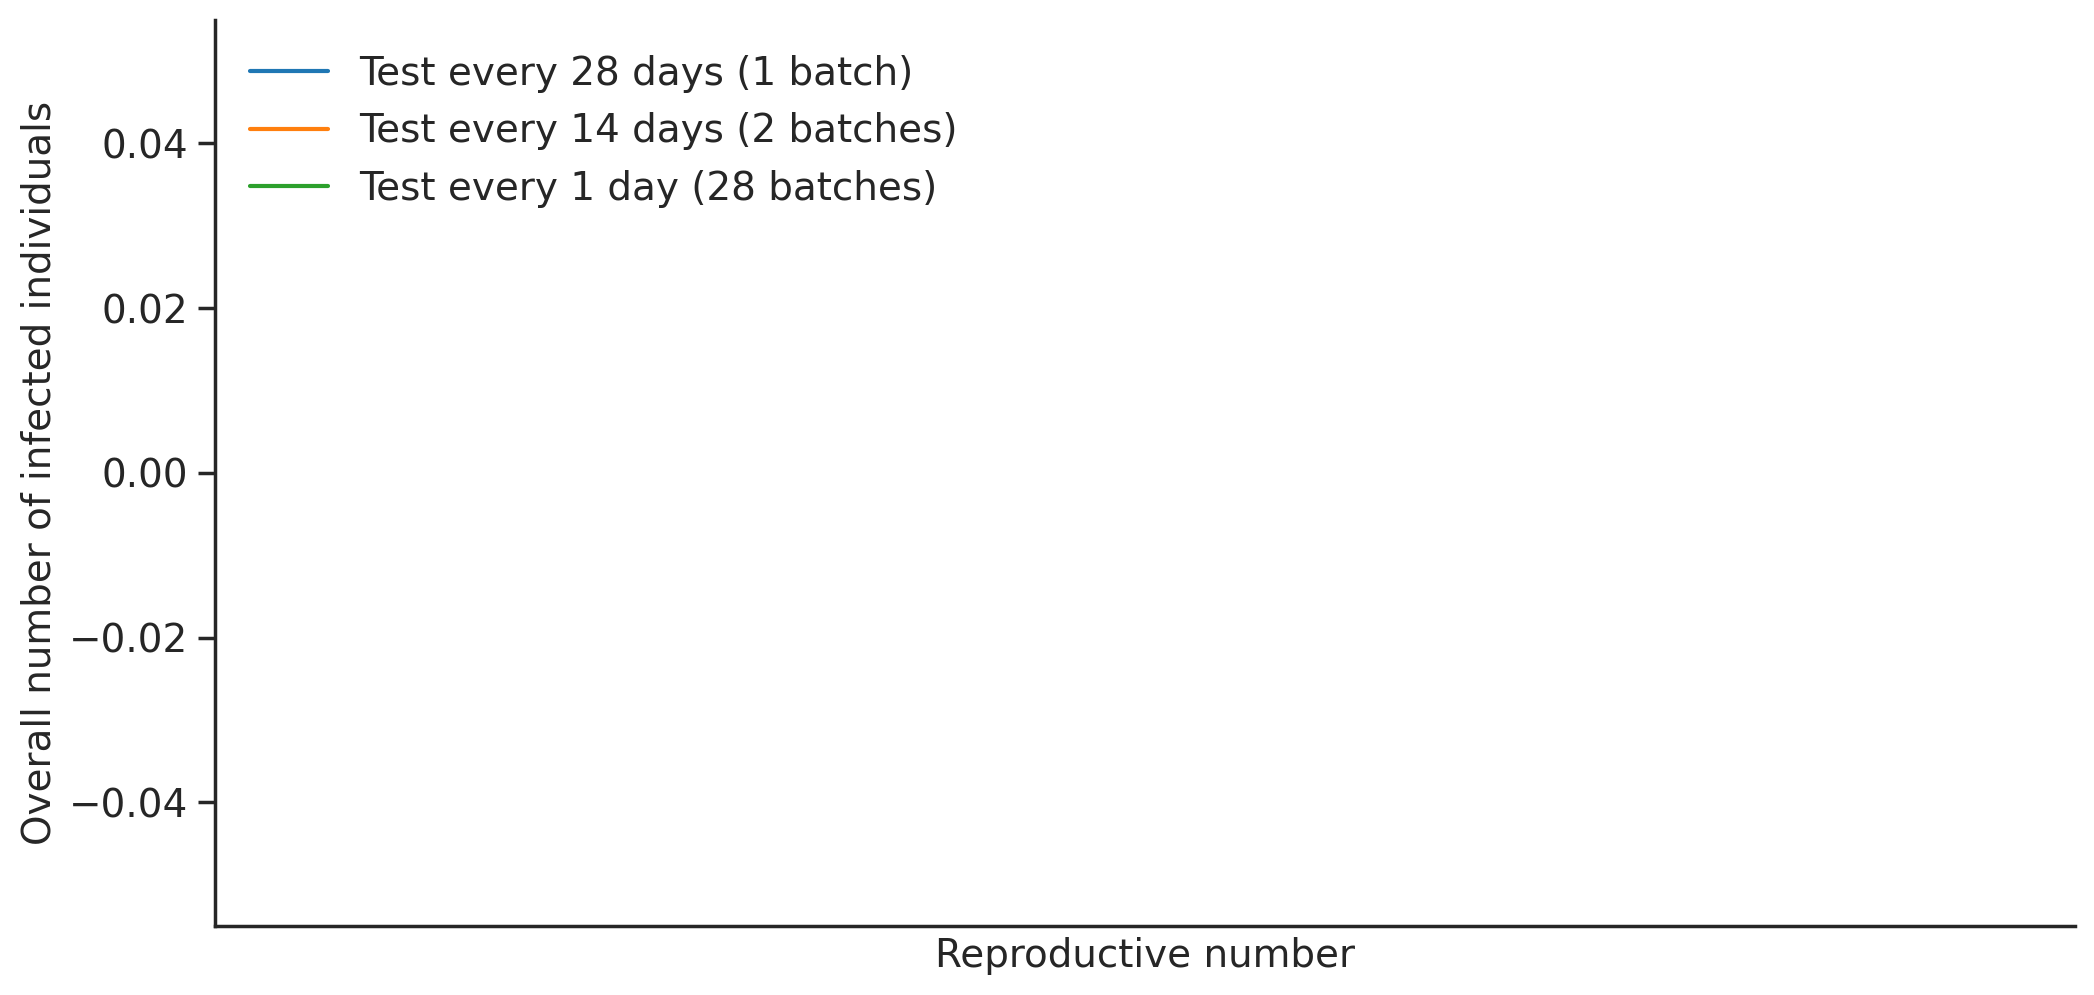

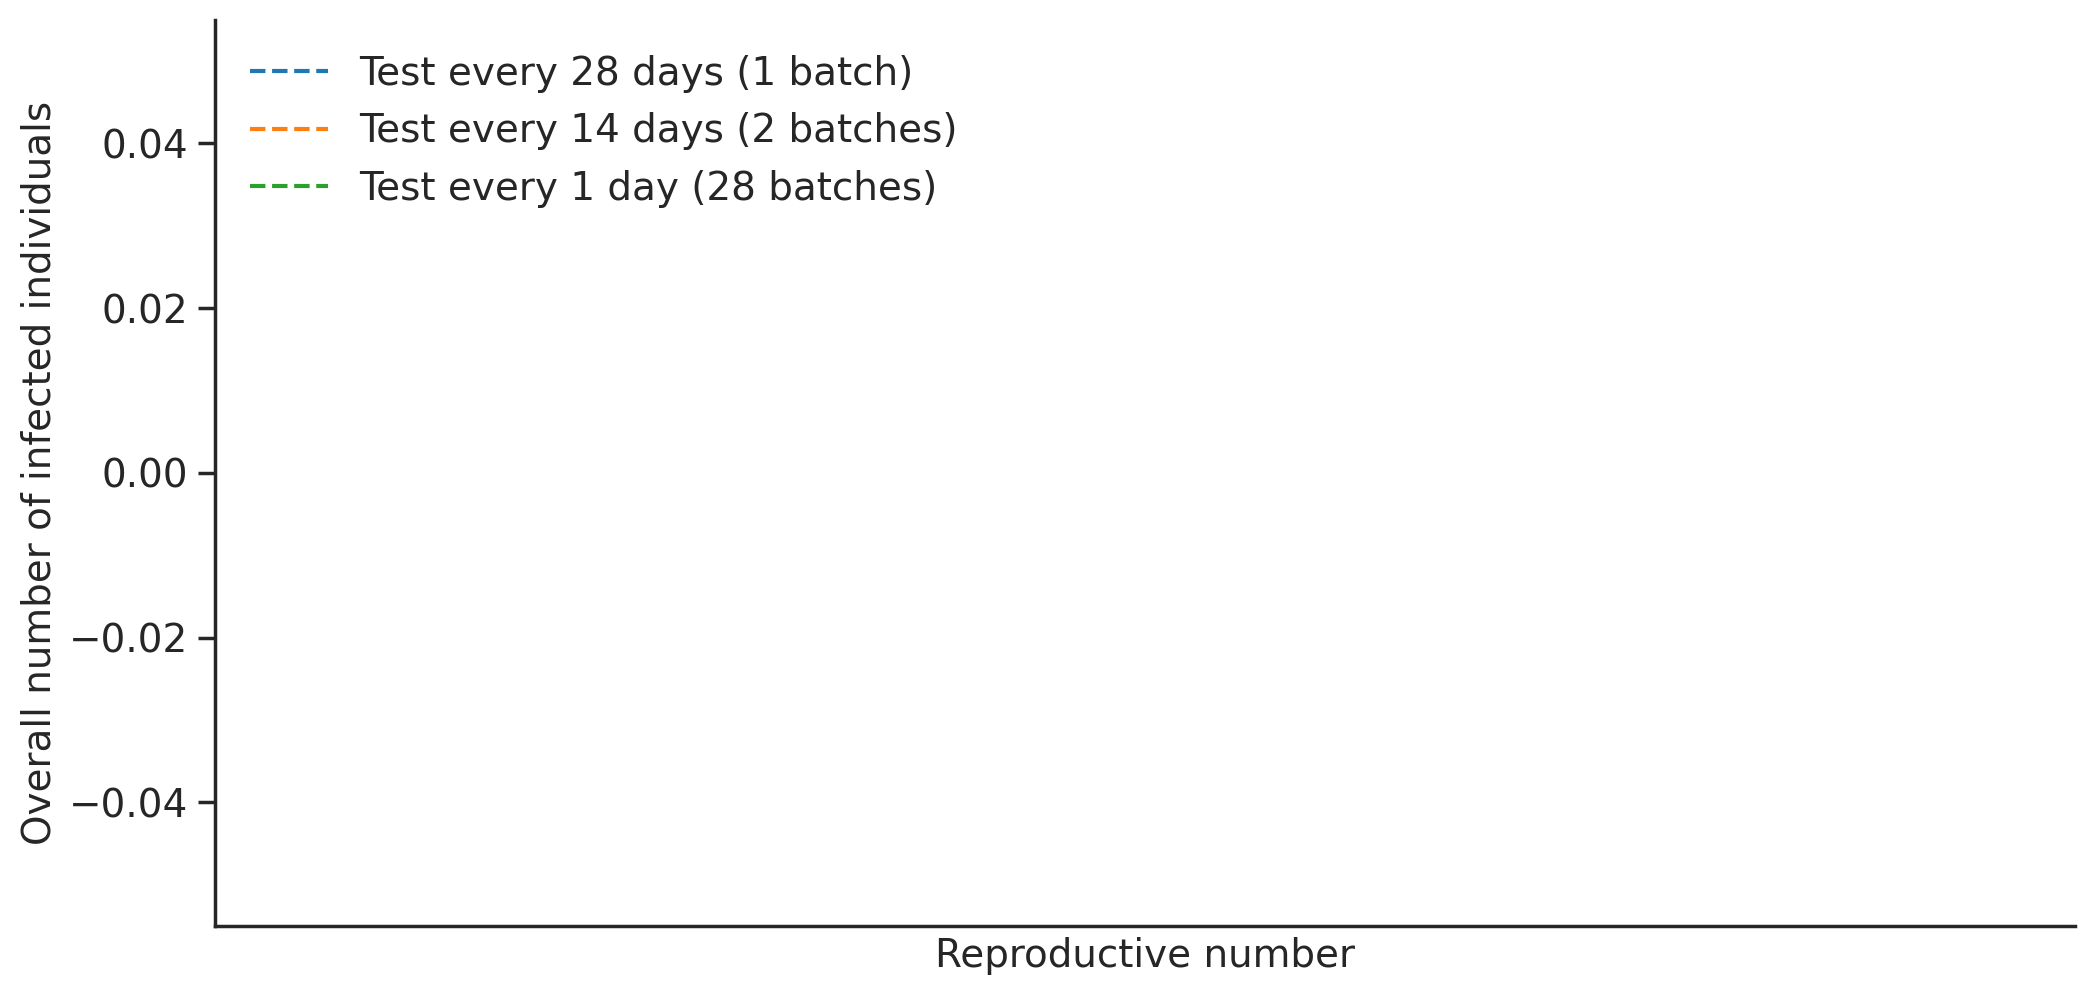

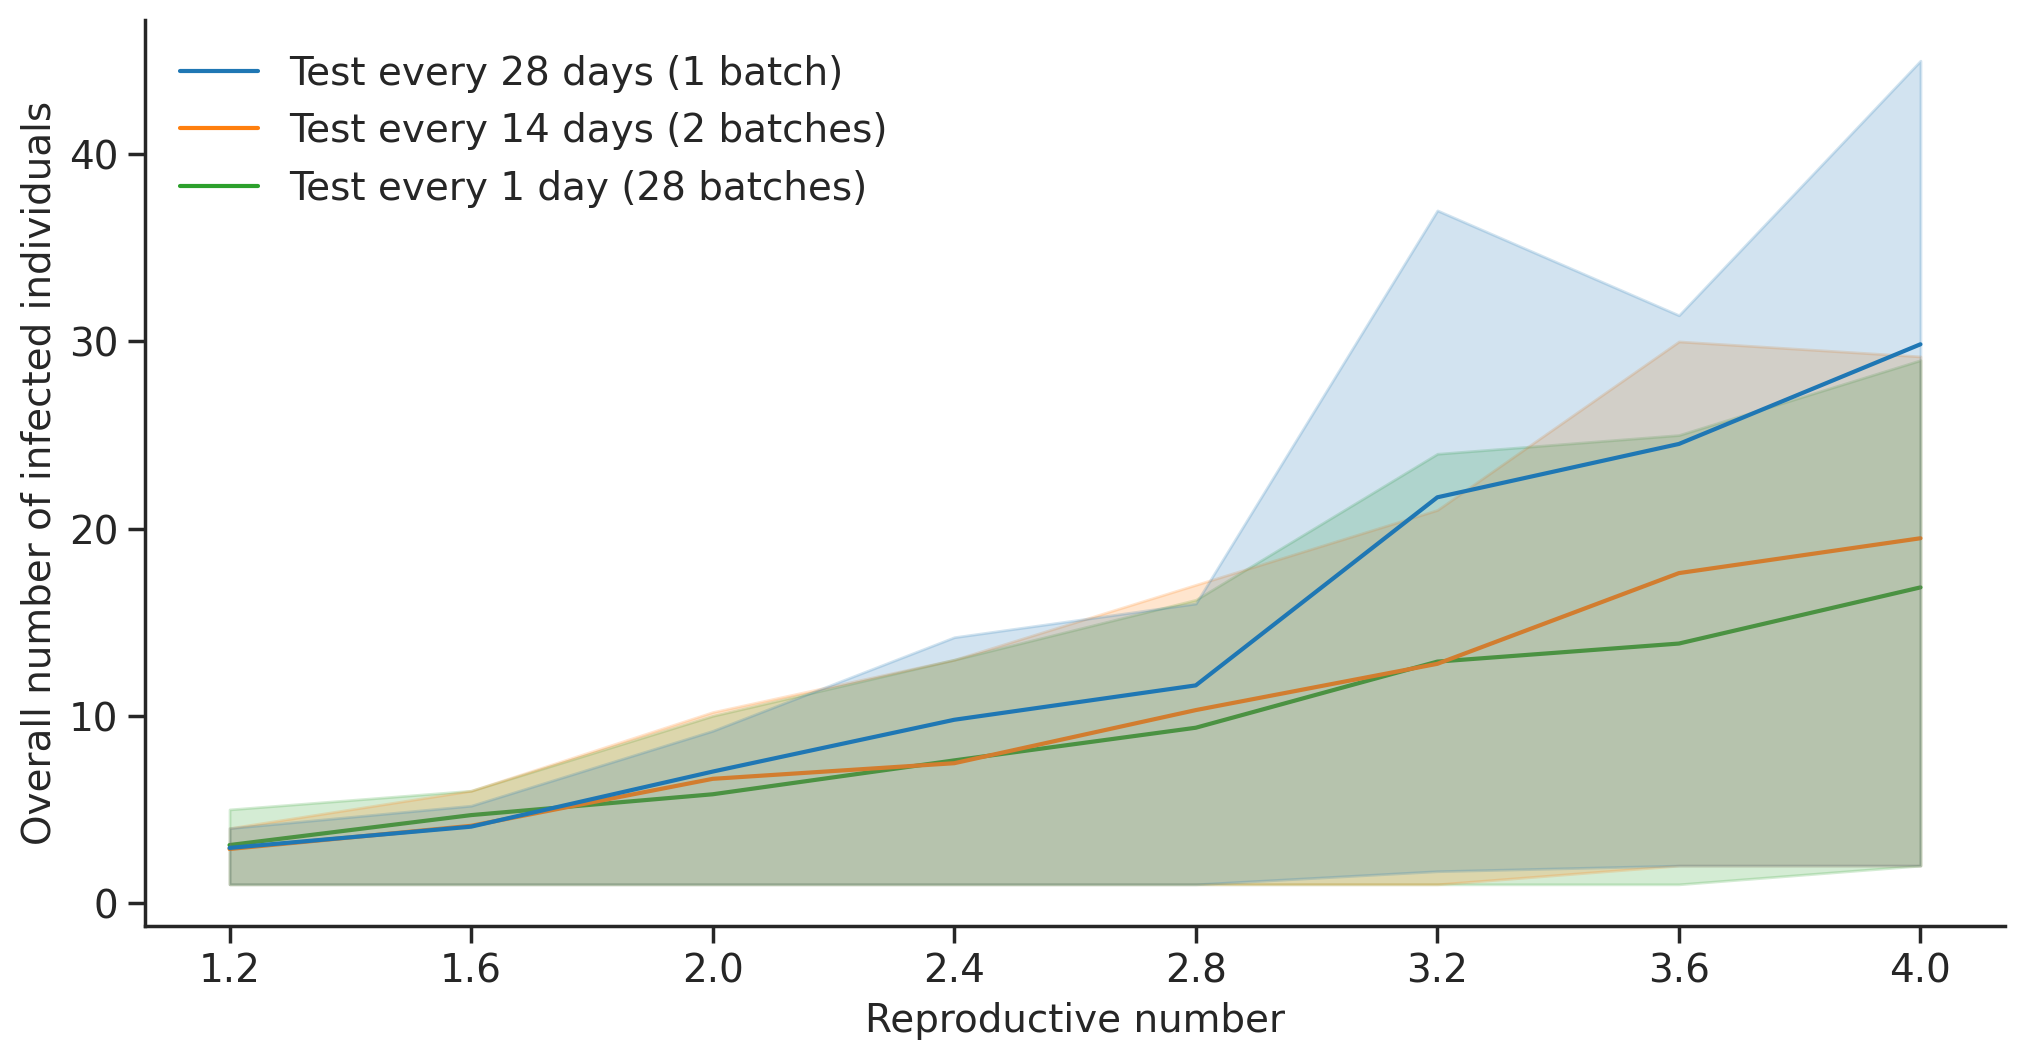

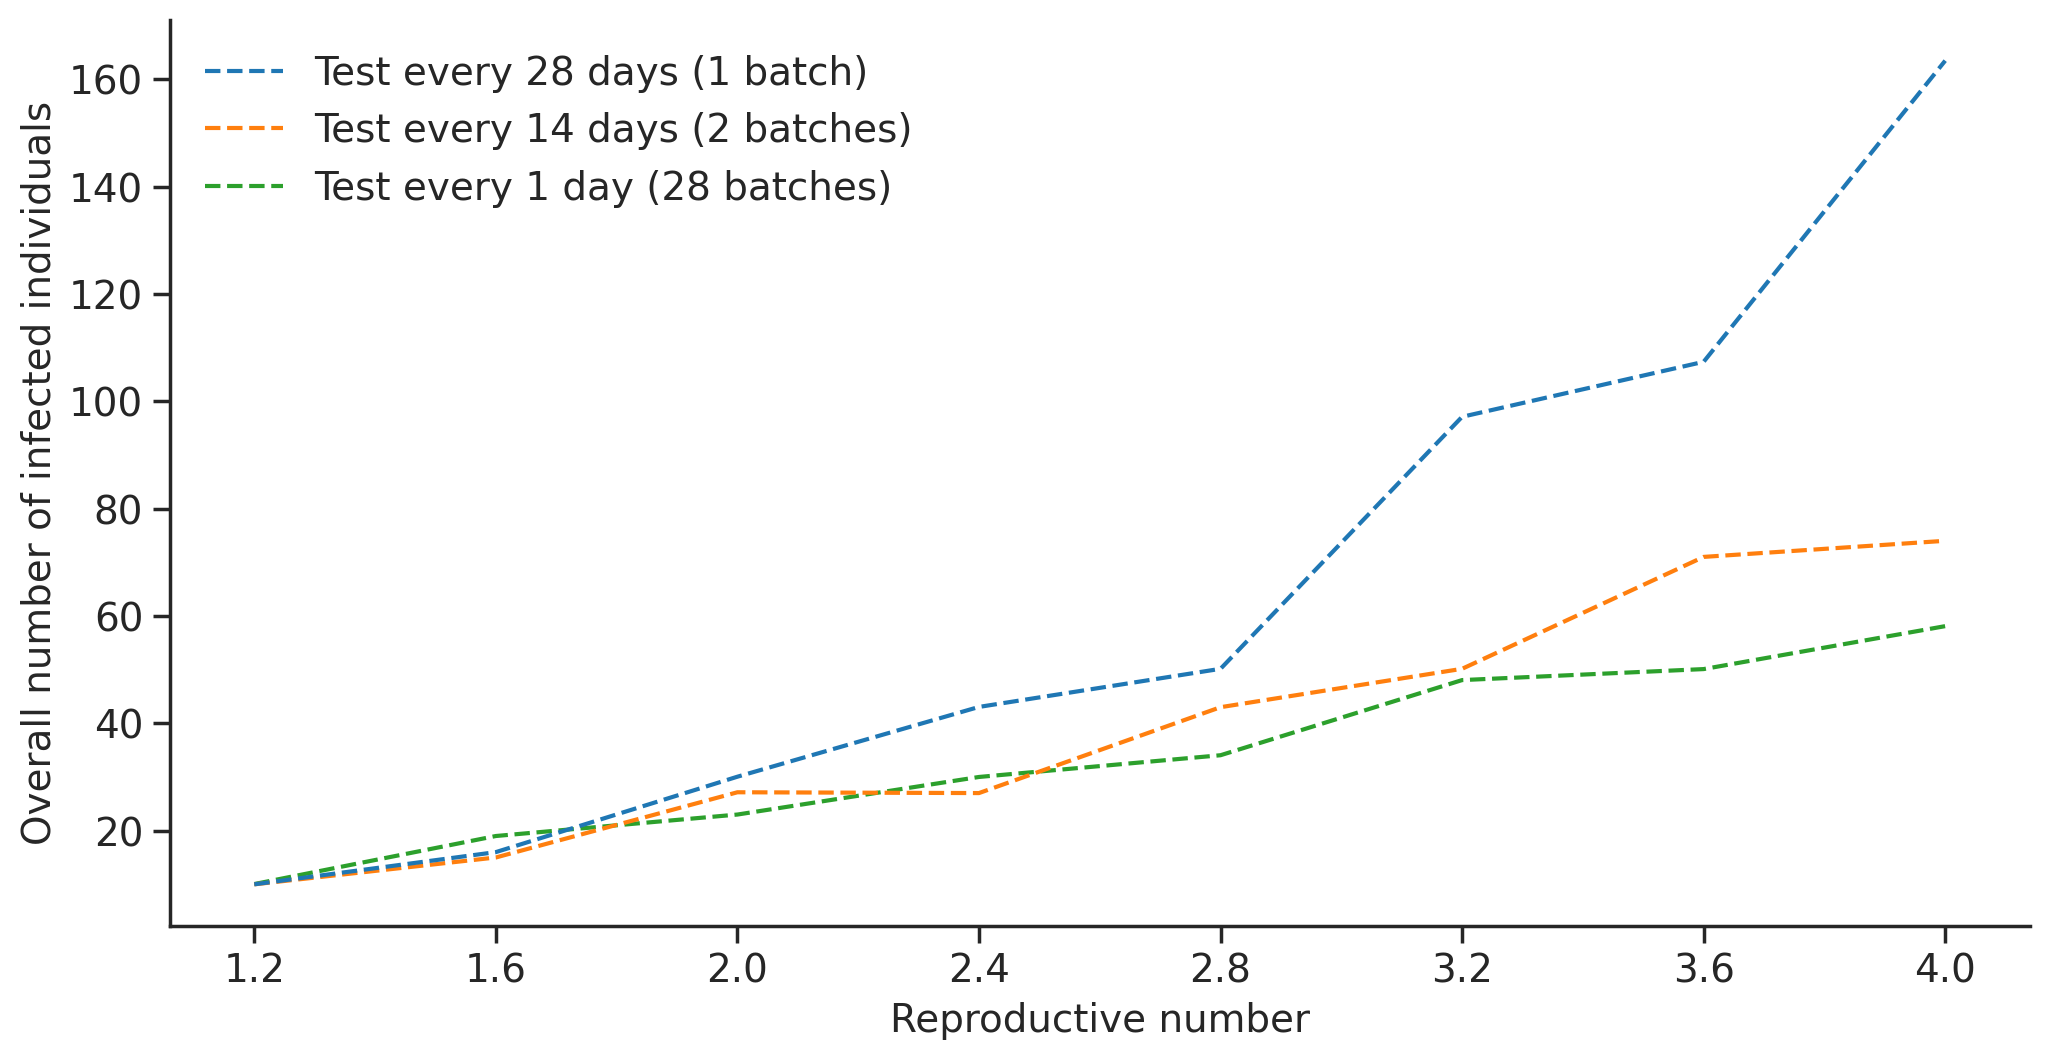

In [33]:

plots = [ ('28_days_G_random', ''), ('28_days_G_gaussian_random_partition','- random partition model')] # ,('28_days_symptomatic', '(symptomatic testing)')]
for t,text in plots:
    df = data[data.experiment==t]
    title = f"Outbreak size per policy " + text
    cost_curves(df,title=title)
    cost_curves(df,title=title, percentile = 0.95)
    

In [29]:
data.experiment.unique()

array(['varying_total', '28_days_G_random',
       '28_days_G_gaussian_random_partition', '28_days_symptomatic',
       'effective_R_2000_nodes', 'external_introductions'], dtype=object)

In [189]:
df = data[data.experiment=='28_days_G_random']
df.groupby(['R','frequency'])['overallInfected/last'].mean().unstack()

frequency,1,7,14,28
R,,,,
1.2,3.2475,2.8200,2.9100,3.1375
1.6,4.0225,4.3975,3.9825,4.3900
2.0,6.0150,5.3150,6.2175,6.2425
2.4,8.0000,7.6450,7.3800,10.7400
2.8,8.8075,9.1700,10.1125,11.6750
3.2,9.5300,10.4125,11.4525,16.8025
3.6,11.7475,12.8250,15.8700,25.3575
4.0,14.4650,15.4000,20.3700,31.4950


In [191]:
temp = df[df.frequency==1]
df['numI_sym/sum'].sum()

0.0

In [151]:
network = random_graph(500, 15)
N = 500
R = 4.4
total = 28
f = 1
D = {"N":N,
     "frequency":f,
     "experiment" : f"28_days_G_{G}",
     "type": f"freq={f}/tot={total}/R={R}",
     "R":R,
     "total": total,
     **network, 
     **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
     "initE": INIT_INFECT,
     "runTillEnd": INIT_INFECT>0,
    }
hist, sum, m = run(D,True)

[INTERVENTIONS @ t = 1.00 (1 (0.20%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	17	tested randomly         [+ 0 positive (0.00 %) +]
	17	tested TOTAL            [+ 0 positive (0.00 %) +]
	0 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 2.00 (1 (0.20%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	17	tested randomly         [+ 0 positive (0.00 %) +]
	17	tested TOTAL            [+ 0 positive (0.00 %) +]
	0 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENT

In [149]:
sum['numI_asym/sum']

0.0

In [150]:
hist['numI_asym']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9119    0.0
9120    0.0
9121    0.0
9122    0.0
9123    0.0
Name: numI_asym, Length: 9124, dtype: float64

In [ ]:
data.set_index('time')['numTested'].fillna(0).plot()

In [ ]:
data.set_index('time')['numPositive'].fillna(0).plot()

In [ ]:
L = []
for n in range(m.numNodes):
    istart = 0
    for t in range(m.tidx+1):
        if not istart and (m.Xseries[t,n]==m.I_sym):
            istart = m.tseries[t]
        if istart and (m.Xseries[t,n]==m.R):
            L.append(m.tseries[t]-istart)
            break    

In [ ]:
plt.hist(L,bins=range(13),density=True)

In [ ]:
m.tidx

In [ ]:
sum(L)/len(L)

In [ ]:
len(L)

In [ ]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, 3400)

In [ ]:
sum(GAMMA)/len(GAMMA)

In [ ]:
plt.hist(list(GAMMA),bins=15,density=True)    